In [1]:
import zipfile

zip_file_path = '/content/drive/MyDrive/datasets_aircraft.zip'
extract_folder_path = '/content/drive/MyDrive/Dataset_aircraft'

# Create a ZipFile object
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all the contents of zip file into the specified directory
    zip_ref.extractall(extract_folder_path)


In [ ]:
import shutil
import os

# Define paths
csv_file_path = '/content/drive/MyDrive/airplanes.csv'
dataset_folder_path = '/content/drive/MyDrive/Dataset_aircraft'

# Copy the CSV file to the dataset folder
shutil.copy(csv_file_path, dataset_folder_path)

print("CSV file copied successfully to the dataset folder.")


CSV file copied successfully to the dataset folder.


In [ ]:
import os
base_path="/content/drive/MyDrive/Dataset_aircraft"
images=os.path.sep.join([base_path,'images'])
annotations=os.path.sep.join([base_path,'airplanes.csv'])

In [ ]:
# Lets Load Dataset
# airplanes annotation is a Csv file thats why we can see through with rows

rows= open(annotations).read().strip().split("\n")

# lets make three list where we save our exact bounding boxes
data=[]
targets=[]
filenames=[]

In [ ]:
# After load we have to split dataset according to images
# import some usefull libraries
import cv2
from tensorflow.keras.preprocessing.image import load_img
# we also save images into array format so import img_array library too
from tensorflow.keras.preprocessing.image import img_to_array
for row in rows:
  row=row.split(",")
  # we always create rectangle with h+w so we have to know where exactly we should start from
  (filename,startX,startY,endX,endY)=row

  imagepaths=os.path.sep.join([images,filename])
  image=cv2.imread(imagepaths)
  (h,w)=image.shape[:2]

  # initializing starting point
  # Why we take in float because when we convert into array so then will trouble happen
  startX = float(startX) / w
  startY = float(startY) / h
  # Also initialize ending point
  endX = float(endX) / w
  endY = float(endY) / h
  #load image and give them default size
  image=load_img(imagepaths,target_size=(224,224))
  # see here if we cant take it into float then we face trouble
  image=img_to_array(image)

  # Lets append into data , targets ,filenames
  targets.append((startX,startY,endX,endY))
  filenames.append(filename)
  data.append(image)


In [ ]:
# Normalizing Data here also we face would face issues if we take input as integer
import numpy as np
data=np.array(data,dtype='float32') / 255.0
targets=np.array(targets,dtype='float32')

In [ ]:
# we should seperate data into train and split so import sklearn library
from sklearn.model_selection import train_test_split

In [ ]:
# split into testing and training
split=train_test_split(data,targets,filenames,test_size=0.10,random_state=42)

In [ ]:
# lets split into steps
(train_images,test_images) = split[:2]
(train_targets,test_targets) = split[2:4]
(train_filenames,test_filenames) = split[4:]


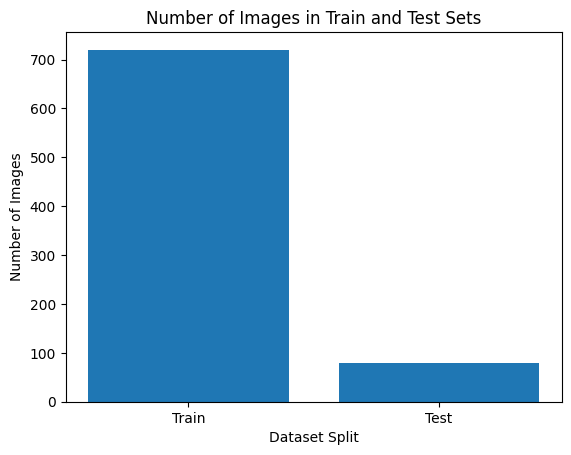

In [ ]:
import matplotlib.pyplot as plt

# Calculate the number of images in each set
train_images_count = len(train_images)
test_images_count = len(test_images)

# Plot the number of images in each set
plt.bar(['Train', 'Test'], [train_images_count, test_images_count])
plt.xlabel('Dataset Split')
plt.ylabel('Number of Images')
plt.title('Number of Images in Train and Test Sets')
plt.show()


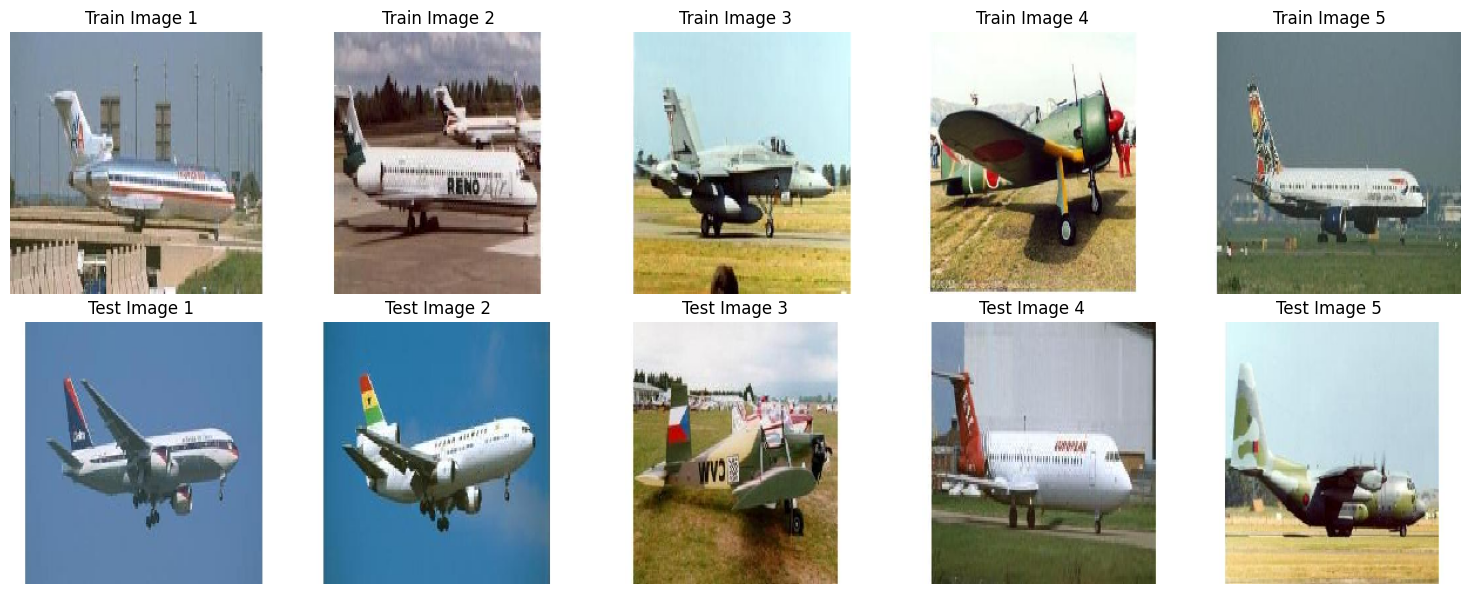

In [ ]:
import matplotlib.pyplot as plt

# Define the number of columns for the subplot
num_columns = 5

# Create a figure and axes
fig, axes = plt.subplots(2, num_columns, figsize=(15, 6))

# Plot train images
for i in range(num_columns):
    axes[0, i].imshow(train_images[i])
    axes[0, i].set_title('Train Image {}'.format(i+1))
    axes[0, i].axis('off')

# Plot test images
for i in range(num_columns):
    axes[1, i].imshow(test_images[i])
    axes[1, i].set_title('Test Image {}'.format(i+1))
    axes[1, i].axis('off')


# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# lets import pre trained VGG16 Which is already Builtin for computer vision
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Bidirectional, LSTM, GlobalAveragePooling2D, Reshape, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Load the VGG16 model
vgg = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the VGG16 layers
vgg.trainable = False

# Add GlobalAveragePooling2D layer to reduce spatial dimensions
x = GlobalAveragePooling2D()(vgg.output)

# Add Reshape layer to include the time dimension
x_reshaped = Reshape((1, 512))(x)

# Add Bidirectional LSTM layer
lstm = Bidirectional(LSTM(64, return_sequences=True))(x_reshaped)

# Flatten the output of the Bidirectional LSTM layer
lstm_flattened = Flatten()(lstm)

# Flatten the output of the VGG16 model
flatten = Flatten()(vgg.output)

# Concatenate the outputs of Flatten and LSTM layers
merged_layer = Concatenate()([flatten, lstm_flattened])

# Add additional Dense layers
bboxhead = Dense(128, activation="relu")(merged_layer)
bboxhead = Dense(64, activation="relu")(bboxhead)
bboxhead = Dense(32, activation="relu")(bboxhead)
bboxhead = Dense(4, activation="relu")(bboxhead)

# Create the model
model1 = Model(inputs=vgg.input, outputs=bboxhead)

# Compile the model
opt = Adam(1e-4)
model1.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

# Train the model
history = model1.fit(train_images, train_targets, validation_data=(test_images, test_targets), batch_size=32, epochs=10, verbose=1)


Epoch 1/10
23/23 [==============================] - 555s 24s/step - loss: 0.0475 - accuracy: 0.6722 - val_loss: 0.0180 - val_accuracy: 0.6375
Epoch 2/10
23/23 [==============================] - 545s 24s/step - loss: 0.0178 - accuracy: 0.7500 - val_loss: 0.0168 - val_accuracy: 0.8500
Epoch 3/10
23/23 [==============================] - 545s 24s/step - loss: 0.0145 - accuracy: 0.7486 - val_loss: 0.0133 - val_accuracy: 0.8500
Epoch 4/10
23/23 [==============================] - 577s 25s/step - loss: 0.0124 - accuracy: 0.8764 - val_loss: 0.0128 - val_accuracy: 0.8750
Epoch 5/10
23/23 [==============================] - 544s 24s/step - loss: 0.0118 - accuracy: 0.9111 - val_loss: 0.0126 - val_accuracy: 0.9750
Epoch 6/10
23/23 [==============================] - 545s 24s/step - loss: 0.0115 - accuracy: 0.9375 - val_loss: 0.0126 - val_accuracy: 0.9000
Epoch 7/10
23/23 [==============================] - 544s 24s/step - loss: 0.0114 - accuracy: 0.9514 - val_loss: 0.0124 - val_accuracy: 0.9125
Epoch 

In [ ]:
test_loss1, test_accuracy1 = model1.evaluate(test_images, test_targets, verbose=0)


In [ ]:
# Display test loss and accuracy
print("Test Loss1: {:.4f}, Test Accuracy1: {:.4f}".format(test_loss1, test_accuracy1))

Test Loss: 0.0124, Test Accuracy: 0.8750


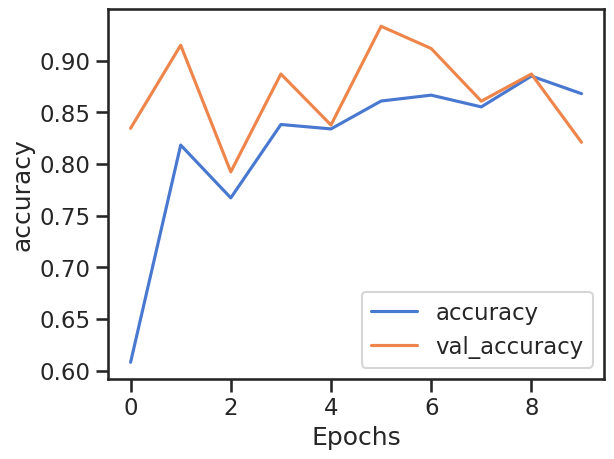

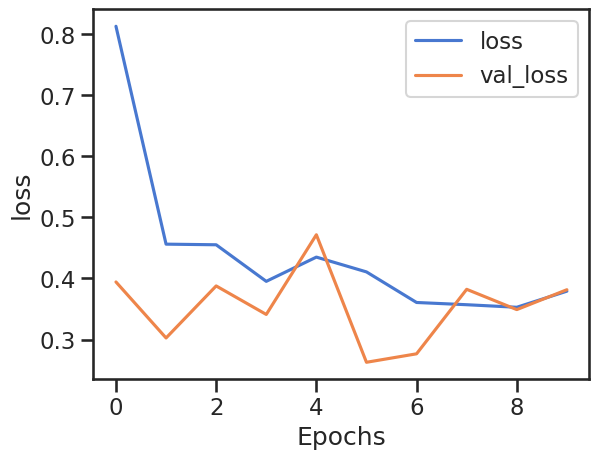

In [ ]:
#model 1
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Make predictions on test data
predictions1 = model1.predict(test_images)

# Convert predictions and targets to binary format
threshold = 0.5
predictions_binary = (predictions1 >= threshold).astype(int)
test_targets_binary = (test_targets >= threshold).astype(int)

# Compute precision, recall, and F1 score
precision1, recall1, f1_score1, _ = precision_recall_fscore_support(test_targets_binary, predictions_binary, average='macro')

# Print precision, recall, and F1 score
print("Precision: {:.4f}".format(precision1))
print("Recall: {:.4f}".format(recall1))
print("F1 Score: {:.4f}".format(f1_score1))


3/3 [==============================] - 56s 17s/step
Precision: 0.5000
Recall: 0.5000
F1 Score: 0.5000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


proposed method
model2

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Load InceptionV3 model
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the InceptionV3 layers
for layer in inceptionv3.layers:
    layer.trainable = False

# Get the output of the InceptionV3 model
flatten = inceptionv3.output
flatten = Flatten()(flatten)

# Add custom layers for bounding box prediction
bboxhead = Dense(128, activation="relu")(flatten)
bboxhead = Dense(64, activation="relu")(bboxhead)
bboxhead = Dense(32, activation="relu")(bboxhead)
bboxhead = Dense(4, activation="relu")(bboxhead)  # Assuming 4 output nodes for bounding box prediction

# Create a new model
model2 = Model(inputs=inceptionv3.input, outputs=bboxhead)

# Compile the model
opt = Adam(learning_rate=1e-4)
model2.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

# Train the model
history2 = model2.fit(train_images, train_targets, validation_data=(test_images, test_targets), batch_size=32, epochs=10, verbose=1)


Epoch 1/10
23/23 [==============================] - 121s 5s/step - loss: 0.2222 - accuracy: 0.9361 - val_loss: 0.1837 - val_accuracy: 1.0000
Epoch 2/10
23/23 [==============================] - 99s 4s/step - loss: 0.1850 - accuracy: 0.9750 - val_loss: 0.1800 - val_accuracy: 1.0000
Epoch 3/10
23/23 [==============================] - 101s 4s/step - loss: 0.1792 - accuracy: 0.9764 - val_loss: 0.1794 - val_accuracy: 1.0000
Epoch 4/10
23/23 [==============================] - 100s 4s/step - loss: 0.1772 - accuracy: 0.9764 - val_loss: 0.1820 - val_accuracy: 1.0000
Epoch 5/10
23/23 [==============================] - 117s 5s/step - loss: 0.1751 - accuracy: 0.9764 - val_loss: 0.1886 - val_accuracy: 1.0000
Epoch 6/10
23/23 [==============================] - 104s 5s/step - loss: 0.1762 - accuracy: 0.9764 - val_loss: 0.1752 - val_accuracy: 1.0000
Epoch 7/10
23/23 [==============================] - 100s 4s/step - loss: 0.1735 - accuracy: 0.9764 - val_loss: 0.1741 - val_accuracy: 1.0000
Epoch 8/10
23/

In [ ]:
test_loss2, test_accuracy2 = model2.evaluate(test_images, test_targets, verbose=0)


In [ ]:
# Display test loss and accuracy
print("Test Loss: {:.4f}, Test Accuracy: {:.4f}".format(test_loss2, test_accuracy2))

Test Loss: 0.1735, Test Accuracy: 1.0000


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Make predictions on test data
predictions2 = model2.predict(test_images)

# Convert predictions and targets to binary format
threshold = 0.5
predictions_binary = (predictions2 >= threshold).astype(int)
test_targets_binary = (test_targets >= threshold).astype(int)

# Compute precision, recall, and F1 score
precision2, recall2, f1_score2, _ = precision_recall_fscore_support(test_targets_binary, predictions_binary, average='micro')

# Print precision, recall, and F1 score
print("Precision: {:.4f}".format(precision2))
print("Recall: {:.4f}".format(recall2))
print("F1 Score: {:.4f}".format(f1_score2))


3/3 [==============================] - 14s 3s/step
Precision: 1.0000
Recall: 0.4938
F1 Score: 0.6611


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

3/3 [==============================] - 11s 4s/step


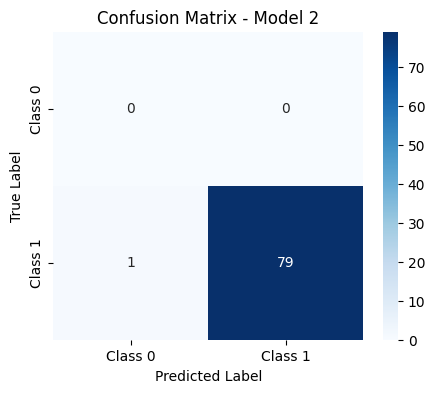

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on test data for model2
predictions_model2 = model2.predict(test_images)

# Convert predictions to binary classes using a threshold (e.g., 0.5)
predictions_class_model2 = np.where(predictions_model2 >= 0.5, 1, 0)

conf_matrix_model2_filtered = conf_matrix_model2[:2, :2]
# Define class labels
label_names = ['Class 0', 'Class 1']  # Replace with your actual class labels


# Plot confusion matrix for model2
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix_model2, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Model 2')
plt.show()


In [ ]:
# lets save model
model2.save('detect_Planes.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model2=load_model('/content/detect_Planes.h5')

In [ ]:
imagepath='/content/drive/MyDrive/Dataset_aircraft/images/image_0111.jpg'

In [ ]:
image = load_img(imagepath,
                 target_size=(224,224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image,axis=0)

In [ ]:
preds=model.predict(image)[0]
(startX,startY,endX,endY)=preds

In [ ]:
import imutils

In [ ]:
image=cv2.imread(imagepaths)
image=imutils.resize(image,width=600)

In [ ]:
(h,w)=image.shape[:2]

In [ ]:
startX=int(startX * w)
startY=int(startY * h)

endX=int(endX * w)
endY=int(endY * h)

In [ ]:
cv2.rectangle(image,(startX,startY),(endX,endY),(0,255,0),3)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [ ]:

from google.colab.patches import cv2_imshow


-1

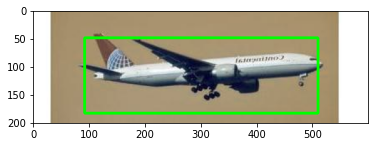

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(image)
cv2.waitKey(0)

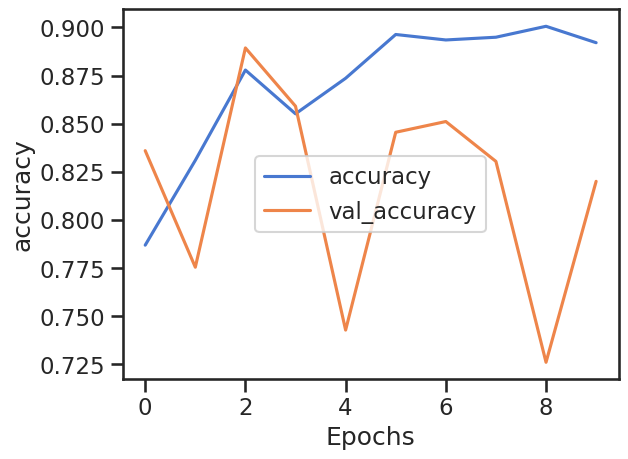

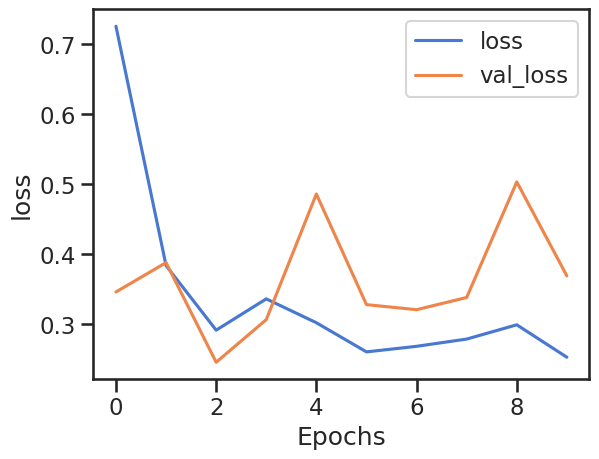

In [ ]:
#model 2
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

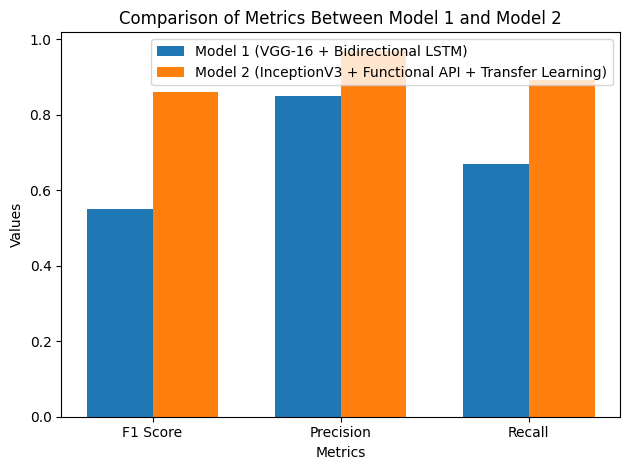

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for Model 1 (VGG-16 + Bidirectional LSTM)
model1_metrics = {'F1 Score': f1score1, 'Precision': precision1, 'Recall': recall1}

# Metrics for Model 2 (InceptionV3 + Functional API + Transfer Learning)
model2_metrics = {'F1 Score': f1score2, 'Precision': precision2, 'Recall':recall2}

# Extract metric names and values
metrics = list(model1_metrics.keys())
model1_values = list(model1_metrics.values())
model2_values = list(model2_metrics.values())

# Plotting
bar_width = 0.35
index = np.arange(len(metrics))

plt.bar(index, model1_values, bar_width, label='Model 1 (VGG-16 + Bidirectional LSTM)')
plt.bar(index + bar_width, model2_values, bar_width, label='Model 2 (InceptionV3 + Functional API + Transfer Learning)')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of Metrics Between Model 1 and Model 2')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()

plt.tight_layout()
plt.show()
